_Autor:_    __Jesús Casado__ <br> _Revisión:_ __8/11/2019__ <br>

__Introducción__<br>


__Cosas que arreglar__ <br>
* El mapa climático no cubre por completo el polígono de la cuenca.
* Rehacer mapas climáticos sobre la malla de MODIS.

***

__Índice__ <br>

In [2]:
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

In [3]:
import numpy.ma as ma

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from netCDF4 import Dataset
from datetime import date, datetime, timedelta

In [13]:
import shapefile as shp
from shapely.geometry.polygon import Polygon
from matplotlib import path

In [6]:
os.chdir('../../Series/notebooks/Spain02/')
%run funciones_Spain02.ipynb
os.chdir(rutaBase)

## Datos

### METEO

```Python
# datos de METEO
rutaMETEO = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Series/METEO/Spain02_v5.0_010reg_aa3d/'
extract_Spain02('pr', rutaMETEO, lonlim=(-4.9, -4.55), latlim=(43.0, 43.25), datelim=('2010-10-01', '2011-09-30'), plot=False)
extract_Spain02.data.shape
```

### IVERCAM

In [71]:
rutaData = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Proyectos/IAHR2020/data/'
os.chdir(rutaData)

```Python
def seriesIVERCAM(file):
    """Importa los archivos csv con la serie temporal de mapas climáticos generados en IVERCAM.
    
    Entradas:
    ---------
    file:    string. Nombre del archivo
    
    Salidas:
    --------
    arr:    array (dates,X,Y). Matriz con los datos
    X:      array. Coordenadas X del mapa
    Y:      array. Coordenadas Y del mapa
    dates:  array. Fechas de cada mapa
    """
    
    # importar csv
    data = pd.read_csv(file)

    # coordenadas X e Y
    XX = data.X
    X = np.sort(np.unique(XX))
    YY = data.Y
    Y = np.sort(np.unique(YY))[::-1]
    nrow, ncol = len(Y), len(X)
    
    # fechas
    data_ = data.drop(['X', 'Y'], axis=1)
    dates = list(data_.columns)
    ntime = len(dates)
    
    # array 3D
    arr = np.empty((ntime, nrow, ncol))
    arr[:,:,:] = np.nan
    for n in range(data_.shape[0]):
        i = np.where(Y == YY[n])[0][0]
        j = np.where(X == XX[n])[0][0]
        arr[:,i,j] = data_.iloc[n,:]

    arr = ma.masked_where(np.isnan(arr), arr)
    
    return arr, X, Y, dates

# precipitación
pcp, Xp, Yp, Tp = seriesIVERCAM('pcp_pred_1000.csv')

plt.figure()
im = plt.imshow(pcp.mean(axis=0))
cb = plt.colorbar(im, shrink=.75)
plt.axis('off');

# temperatura
tmp, Xt, Yt, Tt = seriesIVERCAM('Tmed_pred_1000_IDWz.csv')

plt.figure()
im = plt.imshow(tmp.mean(axis=0))
cb = plt.colorbar(im, shrink=.75)
plt.axis('off');
```

#### NetCDF
Guardo los mapas climáticos como un netCDF.

```Python
# declara el netCDF
nc = Dataset('clima_PdE.nc', 'w', format='NETCDF4')

# definir dimensiones
time = nc.createDimension('time', len(Tp))
x = nc.createDimension('x', len(Xp))
y = nc.createDimension('y', len(Yp))

# definir variables
times = nc.createVariable('time', 'i2', ('time',))
times.units = 'days since {0}'.format(Tp[0])
#times.calendar = "gregorian"
xs = nc.createVariable('X', 'i4', ('x',))
xs.units = 'm'
ys = nc.createVariable('Y', 'i4', ('y',))
ys.units = 'm'
P = nc.createVariable('pcp', 'f4', ('time', 'y', 'x'))
P.units = 'mm'
T = nc.createVariable('tmp', 'f4', ('time', 'y', 'x'))
T.units = '°C'

# atributos
nc.description = 'Caracterización climática de Picos de Europa'
nc.history = 'Created on {0}'.format(date.today())
np.source = 'Jesús Casado Rodríguez'

# asignar valores a las variables
xs[:] = Xp
ys[:] = Yp
times[:] = range(len(Tp))
P[:,:,:] = pcp
T[:,:,:] = tmp

nc.close()
```

In [10]:
# Cargar netCDF con los datos climáticos
nc = Dataset('clima_PdE.nc', 'r', format='NETCDF4')

# extraer variables
X = nc['X'][:].data
Y = nc['Y'][:].data
dates = nc['time'][:].data
dates = [date(1979, 1, 1) + timedelta(days=int(dates[0])) for d in dates]
pcp = nc['pcp'][::]
tmp = nc['tmp'][::]

nc.close()

### Recortar mapas

In [14]:
# ruta cartografía
rutaGIS = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Proyectos/IAHR2020/GIS/'

# importar polígonos de las cuencas
cuenca = shp.Reader(rutaGIS + "mask_1265.shp")

In [50]:
def recortar3D(data, X, Y, mask, buffer=None):
    """Recorta los datos 3D según una máscara 2D.
    
    Entradas:
    ---------
    data:    array (T,Y,X). Serie temporal de mapas
    X:       array. Coordenadas X de las columnas del mapa
    Y:       array. Coordenadas Y de las filas del mapa
    buffer:  boolean. Ditancia a la que hacer el buffer. Por defecto es None y no se hace
    
    Salidas:
    --------
    data_:   array (T,Y_,X_). Serie temporal de mapas recortados
    X_:      array. Coordenadas X de las columnas del mapa 'data_'
    Y_:      array. Coordenadas Y de las filas del mapa 'data_' 
    """
    
    # extraer forma de la máscara
    shape = cuenca.shapeRecords()[0]
    
    # coordenadas x e y de cada vértice del polígono
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    xy = [(x_, y_) for x_, y_ in zip(x, y)]

    
    # crear buffer de la cuenca
    if buffer is not None:
        # crear polígono de la cuenca
        poly_cuenca = Polygon(xy)
        # hacer buffer
        buff_cuenca = poly_cuenca.buffer(buffer)
        # extraer coordenadas de los vértices
        X, Y = buff_cuenca.exterior.coords.xy
        XY = [(x, y) for x, y in zip(X, Y)]
        
    # crear 'path' de la cuenca
    path_cuenca = path.Path(xy)
    
    # puntos de cada celda del mapa
    XX, YY = np.meshgrid(X, Y)
    points = np.array((XX.flatten(), YY.flatten())).T

    # máscara 2D con las celdas dentro de la máscara
    mask2D = path_cuenca.contains_points(points).reshape(XX.shape)

    # máscara 3D a partir de la anterior
    mask3D = np.zeros(data.shape, dtype=bool)
    mask3D[:,:,:] = mask2D[np.newaxis,:,:]

    # recortar 'data' a la cuenca
    data_ = data.copy()
    data_[~mask3D] = np.nan

    # eliminar filas y columnas sin datos
    maskR = np.isnan(data_.sum(axis=0)).all(axis=1)
    maskC = np.isnan(data_.sum(axis=0)).all(axis=0)
    data_ = data_[:,~maskR,:][:,:,~maskC]
    data_ = np.ma.masked_invalid(data_)
    Y_ = Y[~maskR]
    X_ = X[~maskC]
    
    return data_, X_, Y_, x, y

In [68]:
# recortar mapa de precipitación
pcp1265, X1265, Y1265, x, y = recortar3D(pcp, X, Y, cuenca)

In [52]:
# recortar mapa de precipitación
tmp1265, X1265, Y1265, x, y = recortar3D(tmp, X, Y, cuenca)

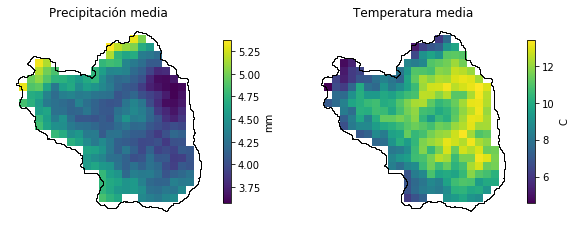

In [69]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
extent = [X1265.min(), X1265.max(), Y1265.min(), Y1265.max()]

# mapa de precipitación media
im = ax[0].imshow(pcp1265.mean(axis=0), extent=extent)
ax[0].plot(x, y, 'k', lw=1)
cb = plt.colorbar(im, shrink=.6, ax=ax[0])
cb.set_label('mm')
ax[0].set_title('Precipitación media')
ax[0].axis('off');

# mapa de temperatura media
im = ax[1].imshow(tmp1265.mean(axis=0), extent=extent)
ax[1].plot(x, y, 'k', lw=1)
cb = plt.colorbar(im, shrink=.6, ax=ax[1])
cb.set_label('C')
ax[1].set_title('Temperatura media')
ax[1].axis('off');

#### Guardar clima del Deva

In [70]:
# declara el netCDF
nc = Dataset('clima_1265.nc', 'w', format='NETCDF4')

# definir dimensiones
time = nc.createDimension('time', len(dates))
x = nc.createDimension('x', len(X1265))
y = nc.createDimension('y', len(Y1265))

# definir variables
times = nc.createVariable('time', 'i2', ('time',))
times.units = 'days since {0}'.format(dates[0])
#times.calendar = "gregorian"
xs = nc.createVariable('X', 'i4', ('x',))
xs.units = 'm'
ys = nc.createVariable('Y', 'i4', ('y',))
ys.units = 'm'
P = nc.createVariable('pcp', 'f4', ('time', 'y', 'x'))
P.units = 'mm'
T = nc.createVariable('tmp', 'f4', ('time', 'y', 'x'))
T.units = '°C'

# atributos
nc.description = 'Caracterización climática de la cuenca alta del río Deva'
nc.history = 'Created on {0}'.format(date.today())
np.source = 'Jesús Casado Rodríguez'

# asignar valores a las variables
xs[:] = X1265
ys[:] = Y1265
times[:] = range(len(dates))
P[:,:,:] = pcp1265
T[:,:,:] = tmp1265

nc.close()